# word2vec from scratch

In [33]:
# open text_dataset.txt
# use nltk to preprocess, tokenise, stem, remove stopwords, lemmatise

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# download nltk data
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# read the file
with open('text_dataset.txt', 'r') as file:
    data = file.read().replace('\n', ' ')
    
# print first 200 chars
print(data[:200])

The Project Gutenberg eBook of The Complete Project Gutenberg Works of Jane Austen      This ebook is for the use of anyone anywhere in the United States and most other parts of the world at no cost a


In [34]:
# tokenise
tokens = word_tokenize(data)
print('Tokenised: ', tokens[:20])

# remove stopwords
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
print('Filtered: ', filtered_tokens[:20])


# lemmatise
lemmatizer = WordNetLemmatizer()
lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
print('Lemmatized: ', lemmatized_tokens[:20])

# lowercase
lowercase_tokens = [word.lower() for word in lemmatized_tokens]
print('Lowercase: ', lowercase_tokens[:20])

data_tokens = lowercase_tokens[:200]


Tokenised:  ['The', 'Project', 'Gutenberg', 'eBook', 'of', 'The', 'Complete', 'Project', 'Gutenberg', 'Works', 'of', 'Jane', 'Austen', 'This', 'ebook', 'is', 'for', 'the', 'use', 'of']
Filtered:  ['Project', 'Gutenberg', 'eBook', 'Complete', 'Project', 'Gutenberg', 'Works', 'Jane', 'Austen', 'ebook', 'use', 'anyone', 'anywhere', 'United', 'States', 'parts', 'world', 'cost', 'almost', 'restrictions']
Lemmatized:  ['Project', 'Gutenberg', 'eBook', 'Complete', 'Project', 'Gutenberg', 'Works', 'Jane', 'Austen', 'ebook', 'use', 'anyone', 'anywhere', 'United', 'States', 'part', 'world', 'cost', 'almost', 'restriction']
Lowercase:  ['project', 'gutenberg', 'ebook', 'complete', 'project', 'gutenberg', 'works', 'jane', 'austen', 'ebook', 'use', 'anyone', 'anywhere', 'united', 'states', 'part', 'world', 'cost', 'almost', 'restriction']


In [35]:
# create lookup table between tokens and indices
word_to_id = {}
id_to_word = {}

for i, word in enumerate(set(data_tokens)):
    if word not in word_to_id:
        word_to_id[word] = i
        id_to_word[i] = word

# print first 20 key-value pairs of both dictionaries
print('Word to ID: ', list(word_to_id.items())[:20])
print('ID to Word: ', list(id_to_word.items())[:20])


Word to ID:  [('hall', 0), ('license', 1), (':', 2), ('hour', 3), ('goodson', 4), ('abbey', 5), ('2010', 6), ('.', 7), ('away', 8), ('15', 9), ('contents', 10), (';', 11), ('works', 12), ('law', 13), ('editor', 14), ('occupation', 15), ('volume', 16), ('somersetshire', 17), ('jane', 18), ('give', 19)]
ID to Word:  [(0, 'hall'), (1, 'license'), (2, ':'), (3, 'hour'), (4, 'goodson'), (5, 'abbey'), (6, '2010'), (7, '.'), (8, 'away'), (9, '15'), (10, 'contents'), (11, ';'), (12, 'works'), (13, 'law'), (14, 'editor'), (15, 'occupation'), (16, 'volume'), (17, 'somersetshire'), (18, 'jane'), (19, 'give')]


In [36]:
import numpy as np

np.random.seed(42)

def one_hot_encode(id, vocab_size):
    return np.eye(vocab_size)[id]

def generate_training_data(corpus, word_to_id, window_size):
    vocab_size = len(word_to_id)
    X = np.zeros((0, vocab_size), dtype=int)
    y = np.zeros((0, vocab_size), dtype=int)
    n = len(corpus)
    for i in range(n):
        context_indices = [j for j in range(max(0, i - window_size), min(n, i + window_size + 1)) if j != i]
        X = np.vstack((X, np.repeat(one_hot_encode(word_to_id[corpus[i]], vocab_size)[np.newaxis, :], len(context_indices), axis=0)))
        y = np.vstack((y, np.array([one_hot_encode(word_to_id[corpus[j]], vocab_size) for j in context_indices])))
    return X, y

In [37]:
X, y = generate_training_data(data_tokens, word_to_id, 2)

In [38]:
X.shape, y.shape

((794, 122), (794, 122))

In [39]:
def softmax(X):
    X_exp = np.exp(X - np.max(X, axis=1, keepdims=True))
    return X_exp / np.sum(X_exp, axis=1, keepdims=True)


def cross_entropy(z, y):
    m = y.shape[0]
    return -np.sum(y * np.log(z + 1e-9)) / m


def init_network(vocab_size, n_embedding):
    scale = np.sqrt(2. / (vocab_size + n_embedding))
    model = {
        'W1': np.random.randn(vocab_size, n_embedding) * scale,
        'W2': np.random.randn(n_embedding, vocab_size) * scale
    }
    return model


def forward(model, X, return_cache=True):
    cache = {}
    cache["a1"] = X @ model["W1"]
    cache["a2"] = cache["a1"] @ model["W2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache
    

def backward(model, X,y,alpha):
    cache = forward(model, X)
    da2 = cache["z"] - y
    dW2 = cache["a1"].T @ da2
    da1 = da2 @ model["W2"].T
    dW1 = X.T @ da1
    
    assert(dW2.shape == model["W2"].shape)
    assert(dW1.shape == model["W1"].shape)
    
    model["W1"] -= alpha * dW1
    model["W2"] -= alpha * dW2
    
    return cross_entropy(cache["z"], y)

Iteration 0, Loss: 4.806594419244795


Iteration 40, Loss: 2.8687797009036977
Iteration 80, Loss: 2.235579424503325
Iteration 120, Loss: 2.1096158723221516
Iteration 160, Loss: 2.0684447329120137


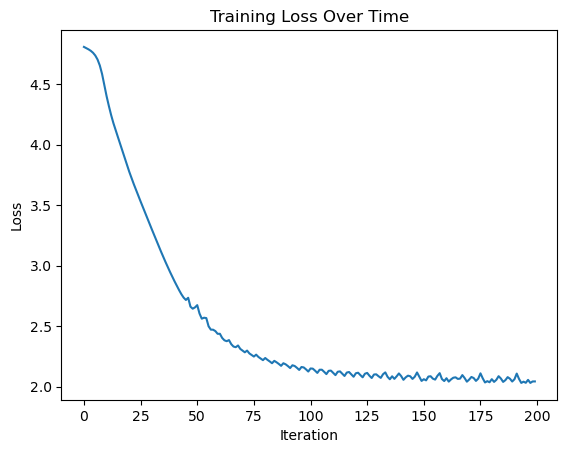

In [41]:
import matplotlib.pyplot as plt
import numpy as np


def train_word2vec(data_tokens, word_to_id, window_size, vocab_size, n_embedding, n_iter, learning_rate):
    # Generate training data
    X, y = generate_training_data(data_tokens, word_to_id, window_size)
    
    # Initialize the network
    model = init_network(vocab_size, n_embedding)
    
    # Training loop
    history = []
    for i in range(n_iter):
        loss = backward(model, X, y, learning_rate)
        history.append(loss)
        if i % 40 == 0:  # Optionally print the loss every 10 iterations
            print(f"Iteration {i}, Loss: {loss}")
    
    # Plotting the loss history
    plt.plot( history )
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.show()
    
    return model
np.random.seed(42)

model = train_word2vec(data_tokens, word_to_id, window_size=2, vocab_size=len(word_to_id), n_embedding=10, n_iter=200, learning_rate=0.02)


In [43]:
restriction = one_hot_encode(word_to_id["restriction"], len(word_to_id))
result = forward(model, [restriction], return_cache=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

cost
almost
whatsoever
.
restriction
states
world
set
part
copy
persuasion
included
pride
dedication
may
works
www.gutenberg.org
freindship
susan
31100
[
away
amusement
sensibility
love
lady
took
anyone
re-use
anywhere
sir
dedicated
give
united
kellynch
use
hart
somersetshire
updated
early
link
mansfield
prejudice
walter
ebook
never
#
25
,
contents
book
project
collection
sense
edited
country
author
park
;
located
term
woodby
(
volume
)
editor
recently
editions
language
law
credits
one
many
1
using
emma
1818
volunteer
start
15
chapter
baronetage
active
june
*
date
check
release
gutenberg
alice
online
accompanying
goodson
license
title
:
elliot
man
widger
abbey
faculty
consolation
distressed
2010
january
complete
austen
northanger
found
file
2013
jane
hour
]
hall
idle
html
note
occupation
english
produced
david


In [44]:
model['W1']

array([[-0.38430035, -1.28848678, -0.18172351, ..., -0.48321309,
        -1.21167911,  0.98049706],
       [-0.23312858,  0.9750206 , -1.4663113 , ...,  0.50162972,
        -1.31029815,  0.73865344],
       [ 1.11569416, -1.41275004, -1.72105565, ...,  1.65836678,
         0.9033421 ,  0.52758124],
       ...,
       [-0.16255025,  0.00909547,  1.69827951, ..., -0.39393002,
        -1.66838676, -0.89931186],
       [ 1.16314858,  0.08042672, -0.57413887, ...,  0.86055485,
        -0.53055888,  1.58864032],
       [ 0.68579178, -0.73033647, -0.70286267, ..., -1.93673286,
        -1.95112824,  1.54609723]])

In [46]:
# Look up the embedding weights for the word "restriction"
restriction_embedding = model['W1'][word_to_id['restriction']]
restriction_embedding

array([-0.39069997, -0.07535885,  0.69088661, -0.79807773,  0.24209137,
       -0.43676966,  0.29752006,  0.43302243, -3.04357205, -1.72799362])

# word2vec with PyTorch

#### Key Differences from the Original (NumPy) Approach:
- The PyTorch version uses an Embedding layer instead of manual one-hot encoding, whic allows for more optimised handling of sparse data.
- PyTorch's nn.CrossEntropyLoss combines the softmax operation and cross-entropy loss into one optimized function, unlike the separate softmax and cross-entropy calculation in the NumPy version.
- Instead of manipulating one-hot encoded vectors, we handle indices directly, reducing memory usage and computational overhead.
- Batching is implemented 

In [133]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import torch

# read the file
with open('text_dataset.txt', 'r') as file:
    data = file.read().replace('\n', ' ')
    
# tokenise
tokens = word_tokenize(data)
print('Tokenised: ', tokens[:20])

# remove stopwords
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
print('Filtered: ', filtered_tokens[:20])

# read the file
with open('text_dataset.txt', 'r') as file:
    data = file.read().replace('\n', ' ')


# lemmatise
lemmatizer = WordNetLemmatizer()
lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
print('Lemmatized: ', lemmatized_tokens[:20])

# lowercase
lowercase_tokens = [word.lower() for word in lemmatized_tokens]
print('Lowercase: ', lowercase_tokens[:20])

# get rid of punctuation
import string
lowercase_tokens = [word for word in lowercase_tokens if word not in string.punctuation]

data_tokens = lowercase_tokens[:6000]

# Create lookup tables
word_to_id = {word: i for i, word in enumerate(set(data_tokens))}
id_to_word = {i: word for word, i in word_to_id.items()}
vocab_size = len(word_to_id)



Tokenised:  ['The', 'Project', 'Gutenberg', 'eBook', 'of', 'The', 'Complete', 'Project', 'Gutenberg', 'Works', 'of', 'Jane', 'Austen', 'This', 'ebook', 'is', 'for', 'the', 'use', 'of']
Filtered:  ['Project', 'Gutenberg', 'eBook', 'Complete', 'Project', 'Gutenberg', 'Works', 'Jane', 'Austen', 'ebook', 'use', 'anyone', 'anywhere', 'United', 'States', 'parts', 'world', 'cost', 'almost', 'restrictions']
Lemmatized:  ['Project', 'Gutenberg', 'eBook', 'Complete', 'Project', 'Gutenberg', 'Works', 'Jane', 'Austen', 'ebook', 'use', 'anyone', 'anywhere', 'United', 'States', 'part', 'world', 'cost', 'almost', 'restriction']
Lowercase:  ['project', 'gutenberg', 'ebook', 'complete', 'project', 'gutenberg', 'works', 'jane', 'austen', 'ebook', 'use', 'anyone', 'anywhere', 'united', 'states', 'part', 'world', 'cost', 'almost', 'restriction']


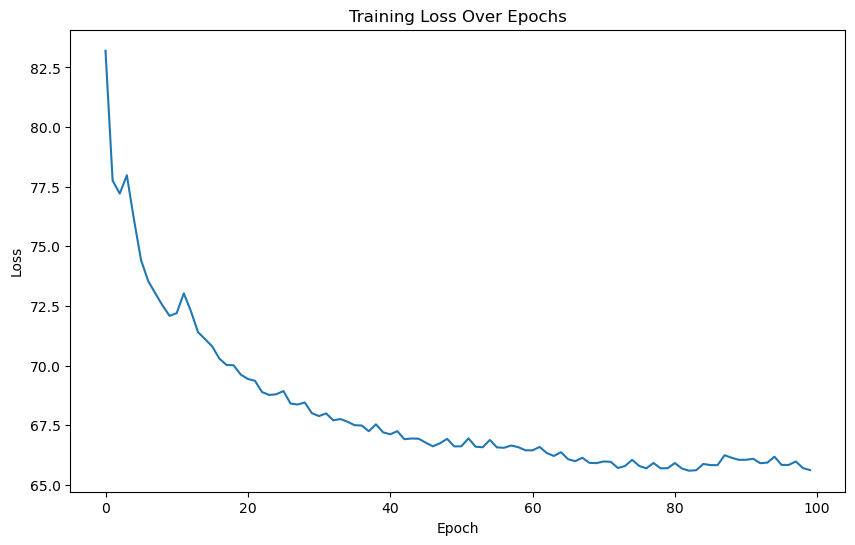

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm


class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Adding more layers
        self.hidden1 = nn.Linear(embedding_dim, embedding_dim * 2)
        self.hidden2 = nn.Linear(embedding_dim * 2, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        # self.dropout = nn.Dropout(p=0.5)

    def forward(self, input_words):
        embeds = self.embeddings(input_words)
        # Applying non-linear activation functions
        hidden1 = F.relu(self.hidden1(embeds))
        hidden2 = F.relu(self.hidden2(hidden1))
        # hidden3 = self.dropout(hidden2)
        out = self.linear(hidden2)
        return out



# Set up the model, loss function, and optimizer
embedding_dim = 100
model = Word2Vec(vocab_size, embedding_dim)

# Generate training data with batching
def generate_batched_data(corpus, word_to_id, window_size, batch_size):
    n = len(corpus)
    num_batches = (n - window_size * 2) // batch_size

    for batch_idx in range(num_batches):
        batch_start = batch_idx * batch_size
        batch_end = batch_start + batch_size
        input_ids = []
        context_ids = []

        for i in range(batch_start, batch_end):
            context_indices = [j for j in range(max(0, i - window_size), min(n, i + window_size + 1)) if j != i]
            for context_index in context_indices:
                input_ids.append(word_to_id[corpus[i]])
                context_ids.append(word_to_id[corpus[context_index]])

        input_ids = torch.tensor(input_ids, dtype=torch.long)
        context_ids = torch.tensor(context_ids, dtype=torch.long)
        yield input_ids, context_ids
        

# Training loop
def train(model, data, word_to_id, window_size, batch_size, epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    losses = []

    epoch_iterator = tqdm(range(epochs), desc="Training Progress", unit="epoch", leave=False)

    for epoch in epoch_iterator:
        total_loss = 0
        batch_generator = generate_batched_data(data, word_to_id, window_size, batch_size)

        for input_ids, context_ids in batch_generator:
            optimizer.zero_grad()
            log_probs = model(input_ids)
            loss = loss_function(log_probs, context_ids)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        losses.append(total_loss)
        
        epoch_iterator.set_description(f"Epoch {epoch+1}/{epochs} Loss: {total_loss:.2f}")
        epoch_iterator.refresh()  
    # Plot the loss over iterations
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(losses)), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.show()

    
train(model, data_tokens, word_to_id, window_size=2, batch_size=512, epochs=100, learning_rate=0.03)

In [136]:
# After training your model
embedding_weights = model.embeddings.weight.data.cpu().numpy()
linear_weights = model.linear.weight.data.cpu().numpy()

print("Embedding Weights:")
print(embedding_weights)


Embedding Weights:
[[-1.3904237   1.6316655   0.73310405 ...  0.06375287  2.2719674
   1.2719074 ]
 [ 0.75213146 -0.24354059  1.6080025  ...  0.78518826 -1.9389652
   0.7559304 ]
 [-1.2488998   0.03486396 -2.1961508  ... -0.84246933 -1.8256373
   0.9463502 ]
 ...
 [ 0.6406975   2.8371642   1.3604952  ... -0.8281421   2.2002277
  -0.6719403 ]
 [ 0.07327046 -0.32596436 -0.84240097 ... -0.6558764  -1.9485059
   0.6949848 ]
 [-2.813357    0.8674626  -2.0289352  ... -2.395054    0.46834147
   0.04676668]]


In [154]:
def get_word_embedding(model, word, word_to_id):
    # Ensure the word is in the vocabulary
    if word not in word_to_id:
        print(f"'{word}' is not in the vocabulary.")
        return None
    
    # Fetch the index of the word
    word_idx = torch.tensor([word_to_id[word]], dtype=torch.long)
    
    # Use the model's embedding layer to get the embedding for the index
    with torch.no_grad():  # We don't need gradients for this operation
        word_embedding = model.embeddings(word_idx).squeeze(0)  # Remove batch dimension
    
    return word_embedding

def get_similar_words_pytorch(model, word, word_to_id, id_to_word, top_n=10):
    # Check if the word is in the vocabulary
    if word not in word_to_id:
        print(f"'{word}' is not in the vocabulary.")
        return []

    # Retrieve the embedding for the specified word
    word_idx = torch.tensor([word_to_id[word]], dtype=torch.long)
    word_embedding = model.embeddings(word_idx).squeeze(0)

    # Compute similarities between the target word and all words in the vocabulary
    # Normalize the embeddings to unit vectors before computing cosine similarity
    embeddings = model.embeddings.weight
    normalized_embeddings = F.normalize(embeddings, p=2, dim=1)
    normalized_word_embedding = F.normalize(word_embedding, p=2, dim=0)
    similarities = torch.matmul(normalized_embeddings, normalized_word_embedding)

    # Get the indices of the top n most similar words
    _, top_indices = torch.topk(similarities, top_n + 1)  # +1 to exclude the word itself

    # Convert indices to words, excluding the word itself
    similar_words = [id_to_word[idx.item()] for idx in top_indices if idx.item() != word_to_id[word]]

    return similar_words[:top_n]



word = 'better'  
word_embedding = get_word_embedding(model, word, word_to_id)
similar_words = get_similar_words_pytorch(model, word, word_to_id, id_to_word, top_n=10)
print(f"Similar words to '{word}': {similar_words}")
print(f"Embedding for '{word}':\n{word_embedding}")

Similar words to 'better': ['youngest', 'convince', 'atmosphere', 'beg', 'prescribed', 'soon', 'confess', 'wished', 'notion', 'solicitous']
Embedding for 'better':
tensor([-0.6071,  1.4115,  0.0865, -1.8073, -1.3477,  1.6845,  0.4384,  0.0867,
        -0.8241,  0.0578,  1.1693,  0.2691,  0.0604, -0.0644, -0.7665, -0.5779,
         0.6972, -2.1495,  1.1482,  1.2985, -0.8920, -0.1459,  0.6877, -0.5342,
         0.2310, -0.6396,  0.2296, -0.8154,  0.8215,  0.6173,  0.4471,  1.1003,
        -1.3093,  1.5898,  0.0179, -0.8791,  1.0853, -0.4197,  1.2414,  2.0271,
        -0.8721,  2.2778,  0.8315,  1.3092, -0.1201,  1.4025, -0.1129, -0.1189,
        -1.2652,  0.8893, -0.6173,  1.0903,  0.2691, -1.0583,  0.1855,  1.7060,
        -1.1349, -1.2543,  1.8843, -2.6723,  0.0154, -0.3240,  0.3095,  1.2929,
        -0.1151,  0.9918, -0.0311, -0.0069, -0.2640, -2.5628, -0.1137, -1.1143,
         0.0283, -0.7032, -2.1650,  0.4606,  0.8144,  0.9153, -0.6523,  0.3222,
        -1.2880,  1.3256,  1.2512,  

In [115]:
# print list of vocab
print(list(word_to_id.keys()))

['feature', 'nation', 'wife', 'distance', 'whole', 'tax', 'scarcely', 'borne', 'fool', 'somersetshire', 'ten', 'pointing', 'deemed', 'offer', 'averted', 'elude', 'contemplated', 'walter', 'book', 'society', 'admiration', 'saving', 'www.gutenberg.org', 'black', 'ball', 'observed', 'proper', 'fetch', 'indeed', 'worsting', 'danger', 'peace', 'power', 'difference', 'settling', 'circle', 'satisfaction', 'plainly', 'quicker', 'foresight', 'replied', 'set', 'giving', 'never', 'foresaw', 'world', 'doubt', 'sister', 'convinced', 'chose', 'pause', 'wise', 'therefore', 'fill', 'became', 'meant', 'provided', 'embarrassment', 'remain', 'passed', 'furnishing', 'fate', 'added', 'convenience', 'wishing', 'revolving', 'would', 'opposite', 'distinction', 'dear', 'next', 'speak', 'admit', 'contentment', 'clergyman', 'must', 'completely', 'informed', 'material', 'disappointed', 'located', 'friend', 'obscure', 'perpetuated', 'properly', 'year', 'saw', 'seventeen', 'drawing-rooms', 'foot', 'intending', 'bet